In [1]:
import sys 
#sys.path.append("codes/modules") # add custom Vibe 's modules
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')

import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time

sys.path.append('/home/hbkoziel/pyfesom/pyfesom/python-gsw/')
import gsw
from tqdm import tqdm_notebook as tqdm

No joblib
no cmocean


In [2]:
# ==============================================================================
# Running this file loads tracers from old FESOM-REcoM2 output file (oce.mean.nc)
# and saves each tracer in an individual file
# 
#  Input:
#  - mesh_id: Name of mesh, will be added to the netcdf name
#  - meshpath: Speciefies where the target mesh is stored
#  - save_netcdf: If true, netcdf will be created
#  - delete_old_netcdf: If a netcdf file with the same name exists, a new cannot 
#    be made. If set to true, an old netcdf with the same name will be deleted
#
#  Output:
#  - netcdf file for each tracer in the old file
#  
#  During running, keep an eye on the output in the terminal, to see if it 
#  makes sense. 
#
# ==============================================================================

In [3]:
def dens0(T,S):
    T68 = T * 1.00024
    a0,a1,a2,a3,a4,a5 = 999.842594, 6.793952e-2, -9.095290e-3, 1.001685e-4, -1.120083e-6, 6.536332e-9
    sw_smow = a0 + (a1 + (a2 + (a3 + (a4 + a5*T68)*T68)*T68)*T68)*T68
    #     UNESCO 1983 eqn(13) p17.
    
    b0, b1, b2, b3, b4 =  8.24493e-1, -4.0899e-3, 7.6438e-5, -8.2467e-7, 5.3875e-9
    c0, c1, c2 = -5.72466e-3, 1.0227e-4, -1.6546e-6
    d0 = 4.8314e-4
    dens = sw_smow + (b0 + (b1 + (b2 + (b3 + b4*T68)*T68)*T68)*T68)*S + (c0 + (c1 + c2*T68)*T68)*S*np.sqrt(S) + d0*S**2
    return dens

In [4]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/scratch/usr/hbkoziel/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

tracername = 'MLD2'
first_year = 2010
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc12'

/scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh


In [5]:
mesh


FESOM mesh:
path                  = /home/hbkoziel/pyfesom/data/mesh/meshArc4.5
alpha, beta, gamma    = 50, 15, -90
number of 2d nodes    = 753179
number of 2d elements = 1480268
number of 3d nodes    = 16950142

        

In [6]:
pressure = gsw.p_from_z(-mesh.z3, mesh.y3, geo_strf_dyn_height=0)

In [7]:
# ==============================================================================
# Settings for netcdf file

save_netcdf       = True                                            # Saves the interpolated field in netcdf file
delete_old_netcdf = True                                            # If a netcdf file with the same name exists it will be deleted
input_directory  = '/scratch/usr/hbkoziel/'+runid+'/netcdf_monthly/'       # Where the netcdf is saved
output_directory  = '/scratch/usr/hbkoziel/'+runid+'/netcdf_monthly/'

In [8]:
for ind in range(0,len(years)):
    netcdf_name       = tracername+'.'+str(years[ind])+'.monthly.nc'
    print years[ind]
    # ==============================================================================
    # Loading data

    ncfile1	= input_directory+'temp.'+str(years[ind])+'.monthly.nc'
    f1	= Dataset(ncfile1,'r')
    t	= f1.variables['temp'][:]
    f1.close()
    
    ncfile2	= input_directory+'salt.'+str(years[ind])+'.monthly.nc'
    f2	= Dataset(ncfile2,'r')
    s	= f2.variables['salt'][:,:]
    f2.close()
    
    print('calculating rho...')
    #sa = gsw.SA_from_SP()
    #ct = gsw.CT_from_pt(SA, pt)
    # ro = gsw.rho(s,t,np.zeros(np.shape(s)))
    ro = dens0(t,s)
    print('done...')
    MLD = np.zeros((12,len(mesh.x2)))
    for month in range(0,12):
        print(month)
        for i in range(0,len(mesh.x2)):
                max_depth = mesh.topo[i]
                ind_depth = np.array(mesh.n32[i,:]) # depth max 580m
                ind_depth = np.reshape(ind_depth, ind_depth.size)
                ind_depth = ind_depth[ind_depth > -999] -1
                
                zzi = np.arange(0,max_depth)
                rho_int = np.interp(zzi,mesh.z3[ind_depth],ro[month,ind_depth])
#                 z = pressure[ind_depth]

#                 tt = t[month,ind_depth]
#                 tt = np.reshape(tt, tt.size)
#                 ss = s[month,ind_depth]
#                 ss = np.reshape(ss, ss.size)
#                 ro = gsw.rho(ss,tt,z)
                #hl_ind = (np.abs(ro[month,ind_depth]-ro[month,ind_depth[0]]-0.3)).argmin(axis=0)
                #MLD[month,i] = mesh.z3[ind_depth[hl_ind]]
                MLD[month,i] = (np.abs(rho_int - rho_int[0] - 0.125)).argmin()
        
            
    tracershape = np.shape(MLD)
    
    # ==============================================================================
    # Testing if a netcdf file with the same name exists, if yes, it must be removed
    # to save a new one.

    if os.path.isfile(output_directory+netcdf_name) and delete_old_netcdf:
      os.remove(output_directory+netcdf_name)
      print "The netcdf file "+netcdf_name+" has been deleted to make room for your file of the same name."
    elif os.path.isfile(netcdf_name):
      statement = "The netcdf file "+netcdf_name+" already exists! It must be removed for a new one to be created. This can be done by changing your settings."
      sys.exit(statement)

    if not os.path.isdir(output_directory):
      os.makedirs(output_directory)
      print 'Directory '+output_directory+' has been created'

    # ==============================================================================
    # Creating netcdf file
    if save_netcdf:  
      import time
      w_nc_fid = Dataset(output_directory+netcdf_name, 'w', format='NETCDF4_CLASSIC')      # Create and open new netcdf file to write to
      w_nc_fid.description = 'MLD with 0.125 kg/m3 criterion'
      w_nc_fid.history     = 'Created ' + time.ctime(time.time())

      nod2d    = w_nc_fid.createDimension('nod2d', mesh.n2d)               # Create dimension: number of 3d nodes
      time	   = w_nc_fid.createDimension('time', tracershape[0])
        
      w_nc_var = w_nc_fid.createVariable('MLD', 'f4',('time','nod2d'))           # 'DIN' is name of saved variable                                                                    # 'f8' sets presicion to 64-bit floating point
      w_nc_var.setncatts({'long_name': u'MLD',\
                          'units': u'm'})
      w_nc_fid.variables['MLD'][:] = MLD  
    
      w_nc_fid.close()                                                     # close the new file                

      cwd = os.getcwd()
      print "New netcdf file (",netcdf_name,") has been created."
      print "Location: "+output_directory
    else:
      print 'You have specified not to save your field in netcdf file'

2010
calculating rho...
done...
0
1
2
3
4
5
6
7
8
9
10
11
The netcdf file MLD2.2010.monthly.nc has been deleted to make room for your file of the same name.
New netcdf file ( MLD2.2010.monthly.nc ) has been created.
Location: /scratch/usr/hbkoziel/Arc12/netcdf_monthly/
2011
calculating rho...
done...
0
1
2
3
4
5
6
7
8
9
10
11
The netcdf file MLD2.2011.monthly.nc has been deleted to make room for your file of the same name.
New netcdf file ( MLD2.2011.monthly.nc ) has been created.
Location: /scratch/usr/hbkoziel/Arc12/netcdf_monthly/
2012
calculating rho...
done...
0
1
2
3
4
5
6
7
8
9
10
11
The netcdf file MLD2.2012.monthly.nc has been deleted to make room for your file of the same name.
New netcdf file ( MLD2.2012.monthly.nc ) has been created.
Location: /scratch/usr/hbkoziel/Arc12/netcdf_monthly/
2013
calculating rho...
done...
0
1
2
3
4
5
6
7
8
9
10
11
The netcdf file MLD2.2013.monthly.nc has been deleted to make room for your file of the same name.
New netcdf file ( MLD2.2013.month

In [9]:
print np.shape(ro)
print ind_depth

(12, 16950142)
[ 753178 1506357 2259536 2958164 3631792 4278615 4900405 5508357 6105548
 6693273 7272020 7841465]


NameError: name 'data' is not defined

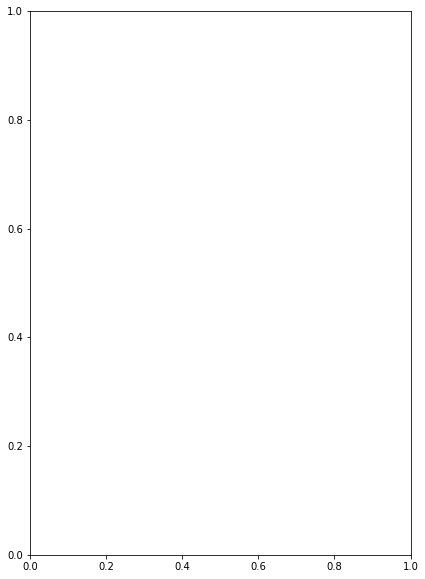

In [10]:
fig = plt.figure(figsize=(15, 10), facecolor='w', edgecolor='k')

ax1      = fig.add_subplot(121)
#hadv[ind_all] = np.nan
del(data)
data = MLD[8,:]
contours = np.arange(0, 201, 1)
eps=(contours.max()-contours.min())/100.
data[data<=contours.min()]=contours.min()+eps
data[data>=contours.max()]=contours.max()-eps
data, elem_no_nan = pf.get_data(data,mesh,0)
m = Basemap(projection='nplaea',boundinglat=73,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cm.inferno, extend='both')
label = 'MLD v2 [m]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%", ticks=np.arange(0,201,20))
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)

ax2      = fig.add_subplot(122)
#hadv[ind_all] = np.nan
del(data)
data = MLD[8,:]
contours = np.arange(0, 41, 1)
eps=(contours.max()-contours.min())/100.
data[data<=contours.min()]=contours.min()+eps
data[data>=contours.max()]=contours.max()-eps
data, elem_no_nan = pf.get_data(data,mesh,0)
m = Basemap(projection='nplaea',boundinglat=73,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cm.inferno, extend='both')
label = 'MLD v2 [m]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%", ticks=np.arange(0,41,2))
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)

In [ ]:
fig = plt.figure(figsize=(15, 10), facecolor='w', edgecolor='k')

ax1      = fig.add_subplot(121)
#hadv[ind_all] = np.nan
del(data)
data = MLD[2,:]
contours = np.arange(0, 201, 1)
eps=(contours.max()-contours.min())/100.
data[data<=contours.min()]=contours.min()+eps
data[data>=contours.max()]=contours.max()-eps
data, elem_no_nan = pf.get_data(data,mesh,0)
m = Basemap(projection='nplaea',boundinglat=73,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cm.inferno, extend='both')
label = 'MLD v2 [m]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%", ticks=np.arange(0,201,20))
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)

ax2      = fig.add_subplot(122)
#hadv[ind_all] = np.nan
del(data)
data = MLD[2,:]
contours = np.arange(0, 41, 1)
eps=(contours.max()-contours.min())/100.
data[data<=contours.min()]=contours.min()+eps
data[data>=contours.max()]=contours.max()-eps
data, elem_no_nan = pf.get_data(data,mesh,0)
m = Basemap(projection='nplaea',boundinglat=73,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cm.inferno, extend='both')
label = 'MLD v2 [m]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%", ticks=np.arange(0,41,2))
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)

In [ ]:
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
plt.plot(ro[month,ind_depth])

In [ ]:
np.shape(s)
#np.shape(t)

In [ ]:
ro = dens0(t,s)

In [ ]:
np.shape(ro)

In [ ]:
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
plt.plot(ro[month,ind_depth],-mesh.z3[ind_depth])

In [ ]:
hl_ind = (np.abs(ro[month,ind_depth]-ro[month,ind_depth[0]]-0.125)).argmin(axis=0)
hl_ind

In [ ]:
mesh.z3[ind_depth[hl_ind]]

In [ ]:
ro[month,ind_depth]